In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [62]:
# Data load
df_obd = pd.read_csv("data/OBD-II/exp1_14drivers_14cars_dailyRoutes.csv")
df_obd.head(3)

,TIMESTAMP,MARK,MODEL,CAR_YEAR,ENGINE_POWER,AUTOMATIC,VEHICLE_ID,BAROMETRIC_PRESSURE(KPA),ENGINE_COOLANT_TEMP,FUEL_LEVEL,ENGINE_LOAD,AMBIENT_AIR_TEMP,ENGINE_RPM,INTAKE_MANIFOLD_PRESSURE,MAF,LONG TERM FUEL TRIM BANK 2,FUEL_TYPE,AIR_INTAKE_TEMP,FUEL_PRESSURE,SPEED,SHORT TERM FUEL TRIM BANK 2,SHORT TERM FUEL TRIM BANK 1,ENGINE_RUNTIME,THROTTLE_POS,DTC_NUMBER,TROUBLE_CODES,TIMING_ADVANCE,EQUIV_RATIO,MIN,HOURS,DAYS_OF_WEEK,MONTHS,YEAR
0,1.502903e+12,chevrolet,agile,2011.0,"1,4",n,car1,100.0,80.0,"48,60%","33,30%",NaN,1009.0,49.0,"4,49",NaN,Biodiesel_Ethanol,59.0,NaN,0.0,NaN,NaN,00:03:28,25%,MIL is OFF0 codes,NaN,"56,9%","1,0%",13.0,16.0,2.0,8.0,2017.0
1,1.502903e+12,chevrolet,agile,2011.0,"1,4",n,car1,100.0,80.0,"48,60%","32,50%",NaN,1003.0,52.0,"4,51",NaN,Biodiesel_Ethanol,59.0,NaN,0.0,NaN,NaN,00:03:35,25%,MIL is OFF0 codes,NaN,"56,5%","1,0%",13.0,16.0,2.0,8.0,2017.0
2,1.502903e+12,chevrolet,agile,2011.0,"1,4",n,car1,100.0,80.0,"48,60%","32,90%",NaN,995.0,51.0,"4,48",NaN,Biodiesel_Ethanol,59.0,NaN,0.0,NaN,NaN,00:03:43,25%,MIL is OFF0 codes,NaN,"57,3%","1,0%",13.0,16.0,2.0,8.0,2017.0


In [63]:
# Quick inspection
df_obd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60439 entries, 0 to 60438
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TIMESTAMP                    47514 non-null  float64
 1   MARK                         47459 non-null  object 
 2   MODEL                        47459 non-null  object 
 3   CAR_YEAR                     47459 non-null  float64
 4   ENGINE_POWER                 47459 non-null  object 
 5   AUTOMATIC                    47459 non-null  object 
 6   VEHICLE_ID                   47514 non-null  object 
 7   BAROMETRIC_PRESSURE(KPA)     10212 non-null  float64
 8   ENGINE_COOLANT_TEMP          33964 non-null  float64
 9   FUEL_LEVEL                   2994 non-null   object 
 10  ENGINE_LOAD                  30972 non-null  object 
 11  AMBIENT_AIR_TEMP             3619 non-null   float64
 12  ENGINE_RPM                   33859 non-null  float64
 13  INTAKE_MANIFOLD_

In [64]:
# Normalization
df_obd["MARK"] = df_obd["MARK"].str.title().str.strip()
df_obd["MODEL"] = df_obd["MODEL"].str.title().str.strip()

df_obd["VEHICLE"] = (df_obd["MARK"].fillna("") + " " + df_obd["MODEL"].fillna("")).str.strip()
df_obd.loc[df_obd["VEHICLE"] == "", "VEHICLE"] = df_obd["VEHICLE_ID"]

In [65]:
# DTC Summary Check
df_obd.groupby(["DTC_NUMBER", "TROUBLE_CODES"]).size().reset_index(name="row_count").sort_values("DTC_NUMBER")

,DTC_NUMBER,TROUBLE_CODES,row_count
0,MIL is OFF0 codes,C0300,5673
1,MIL is OFF0 codes,P0078B0004P3000,12
2,MIL is OFF0 codes,P0078U1004P3000,29
3,MIL is OFF0 codes,P0079C1004P3000,28
4,MIL is OFF0 codes,P0079P1004P3000,5
5,MIL is OFF0 codes,P0079P2004P3000,46
6,MIL is OFF0 codes,P007EP2036P18D0,19
7,MIL is OFF0 codes,P007EP2036P18E0,18
8,MIL is OFF0 codes,P007EP2036P18F0,9
9,MIL is OFF0 codes,P007FP2036P18D0,3


In [66]:
# Drop
df_obd.drop(columns=["DTC_NUMBER", "VEHICLE_ID", "MARK", "MODEL"], inplace=True)

In [67]:
# DTC Parsiong
pattern = r"[PBCU]\d{4}"

def extract_codes(x):
    if pd.isna(x) or x in ["None", "nan"]:
        return []
    return re.findall(pattern, str(x))

df_obd["codes_list"] = df_obd["TROUBLE_CODES"].apply(extract_codes)
df_obd["code_count"] = df_obd["codes_list"].apply(len)

df_obd["tc_P"] = df_obd["codes_list"].apply(lambda lst: sum(c.startswith("P") for c in lst))
df_obd["tc_B"] = df_obd["codes_list"].apply(lambda lst: sum(c.startswith("B") for c in lst))
df_obd["tc_C"] = df_obd["codes_list"].apply(lambda lst: sum(c.startswith("C") for c in lst))
df_obd["tc_U"] = df_obd["codes_list"].apply(lambda lst: sum(c.startswith("U") for c in lst))

In [68]:
# Fault Flag
df_obd["fault_flag"] = df_obd["codes_list"].apply(lambda x: 1 if len(x) > 0 else 0)

In [69]:
# Clean % cols
def clean_percent(x):
    if pd.isna(x):
        return np.nan
    x = str(x).replace("%", "").replace(",", ".")
    try:
        return float(x)
    except:
        return np.nan

percent_cols = [
    "FUEL_LEVEL", "ENGINE_LOAD", "THROTTLE_POS",
    "SHORT TERM FUEL TRIM BANK 1", "SHORT TERM FUEL TRIM BANK 2",
    "LONG TERM FUEL TRIM BANK 2","TIMING_ADVANCE", "EQUIV_RATIO",
]

for col in percent_cols:
    df_obd[col] = df_obd[col].apply(clean_percent)

In [70]:
# Engine runtime to sec
def runtime_to_seconds(x):
    if pd.isna(x): return np.nan
    try:
        h, m, s = x.split(":")
        return int(h)*3600 + int(m)*60 + int(s)
    except:
        return np.nan

df_obd["ENGINE_RUNTIME"] = df_obd["ENGINE_RUNTIME"].apply(runtime_to_seconds)

In [71]:
# Timestamp and sort by vehicle
df_obd["TIMESTAMP"] = pd.to_datetime(df_obd["TIMESTAMP"], unit="ms", errors="coerce")
df_obd = df_obd.dropna(subset=["TIMESTAMP"])
df_obd = df_obd.sort_values(["VEHICLE", "TIMESTAMP"])
df_obd = df_obd.set_index("TIMESTAMP").sort_index()

In [72]:
# MAF Cleaning
df_obd["MAF"] = (df_obd["MAF"].astype(str).str.replace(",", ".", regex=False))
df_obd["MAF"] = pd.to_numeric(df_obd["MAF"], errors="coerce")

In [73]:
# PID Support Matrix
pid_cols = [
    "BAROMETRIC_PRESSURE(KPA)", "ENGINE_COOLANT_TEMP",
    "FUEL_LEVEL", "ENGINE_LOAD", "AMBIENT_AIR_TEMP",
    "ENGINE_RPM", "INTAKE_MANIFOLD_PRESSURE",
    "MAF", "AIR_INTAKE_TEMP", "FUEL_PRESSURE", "SPEED"
]

pid_support = (df_obd.groupby("VEHICLE")[pid_cols].apply(lambda x: x.notna().mean()))

pid_support

,BAROMETRIC_PRESSURE(KPA),ENGINE_COOLANT_TEMP,FUEL_LEVEL,ENGINE_LOAD,AMBIENT_AIR_TEMP,ENGINE_RPM,INTAKE_MANIFOLD_PRESSURE,MAF,AIR_INTAKE_TEMP,FUEL_PRESSURE,SPEED
VEHICLE,,,,,,,,,,,
Chevrolet Agile,0.211721,0.211500,0.209738,0.198355,0.129103,0.198575,0.211500,0.198575,0.211500,0.0,0.998384
Citroen C3,0.000000,0.730583,0.000000,0.914078,0.000000,0.866990,0.879126,0.000000,0.918932,0.0,0.892718
Fiat Palio,0.000000,0.715644,0.000000,0.310549,0.000000,0.711877,0.716003,0.000000,0.715823,0.0,0.996053
Fiat Siena,0.000000,0.857143,0.000000,1.000000,0.000000,0.714286,0.857143,0.000000,0.857143,0.0,0.857143
Ford Eco_Sport,0.000000,0.992754,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.0,0.934783
Ford Focus,0.000000,0.984221,0.000000,0.988166,0.000000,0.992110,0.986193,0.000000,0.982249,0.0,0.948718
Honda Fit,0.000000,0.996678,0.000000,0.997785,0.000000,0.978959,0.996678,0.000000,0.996678,0.0,0.967885
Nissan Versa,0.000000,0.995713,0.000000,0.960343,0.997320,0.960343,0.000000,0.959807,0.997320,0.0,0.935155
Peugeot 208_Allure,0.000000,0.937687,0.000000,0.938850,0.000000,0.938850,0.938019,0.000000,0.938019,0.0,0.936025


In [74]:
# Araç bazında 4 ana PID'in veri doluluk oranı
coverage = df_obd.groupby("VEHICLE")[[
    "ENGINE_RPM","SPEED","ENGINE_COOLANT_TEMP","ENGINE_LOAD"
]].apply(lambda x: x.notna().mean().round(3))

coverage

,ENGINE_RPM,SPEED,ENGINE_COOLANT_TEMP,ENGINE_LOAD
VEHICLE,,,,
Chevrolet Agile,0.199,0.998,0.212,0.198
Citroen C3,0.867,0.893,0.731,0.914
Fiat Palio,0.712,0.996,0.716,0.311
Fiat Siena,0.714,0.857,0.857,1.000
Ford Eco_Sport,1.000,0.935,0.993,1.000
Ford Focus,0.992,0.949,0.984,0.988
Honda Fit,0.979,0.968,0.997,0.998
Nissan Versa,0.960,0.935,0.996,0.960
Peugeot 208_Allure,0.939,0.936,0.938,0.939


In [75]:
# %70 sensör doluluk kriterini sağlayan araçlar
valid_vehicles = coverage[
    (coverage.ENGINE_RPM > 0.70) &
    (coverage.ENGINE_COOLANT_TEMP > 0.70) &
    (coverage.ENGINE_LOAD > 0.70)
].index.tolist()

valid_vehicles

['Citroen C3',
 'Fiat Siena',
 'Ford Eco_Sport',
 'Ford Focus',
 'Honda Fit',
 'Nissan Versa',
 'Peugeot 208_Allure',
 'Renault Duster',
 'Toyota Corolla',
 'Volkswagen Polo',
 'Volkswagen Voyage',
 'car5']

In [76]:
# Filtering
df_obd = df_obd[df_obd["VEHICLE"].isin(valid_vehicles)]

In [77]:
# # Zaman ve araç bazında sıralama
df_obd = df_obd.sort_values(["VEHICLE", df_obd.index.name])

# Araç bazında ardışık kayıtlar arası zaman farkı (saniye)
df_obd["gap"] = (df_obd.groupby("VEHICLE").apply(lambda g: g.index.to_series().diff().dt.total_seconds()).reset_index(level=0, drop=True)
                )
# 5 dakikadan (300 sn) büyük boşluk yeni sürüş oturumu kabul ediliyor
df_obd["session_id"] = (df_obd.groupby("VEHICLE")["gap"].transform(lambda s: (s > 300).cumsum()))

df_obd.drop(columns=["gap"], inplace=True)

In [78]:
# Sanity Check
session_summary = (df_obd.groupby(["VEHICLE","session_id"])["ENGINE_RPM"].count().reset_index(name="n_samples"))

session_summary

,VEHICLE,session_id,n_samples
0,Citroen C3,0,15
1,Citroen C3,1,86
2,Citroen C3,2,62
3,Citroen C3,3,3
4,Citroen C3,4,45
...,...,...,...
191,Volkswagen Voyage,0,2
192,Volkswagen Voyage,1,83
193,Volkswagen Voyage,2,95
194,car5,0,8


In [79]:
# Araç bazlı sensör davranışını özetlemek için rolling window istatistikleri (son 5, 10, 20 kaydın ss'i) üretiyoruz.
# Her araç, kendi geçmiş değerleri üzerinden değerlendiriliyor (araçlar birbirine karışmıyor).
# mean → kısa dönem ortalama seviye
# std  → kısa dönem oynaklık / dengesizlik
# Rolling window boyutları
windows = [5, 10, 20]

# Trend fonksiyonu (slope)
def trend_series(x, window=20):
    return x.rolling(window).apply(
        lambda v: np.polyfit(range(len(v)), v, 1)[0] if np.all(~np.isnan(v)) else np.nan,
        raw=False
    )


for w in windows:
    df_obd[f"rpm_mean_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_RPM"].transform(lambda x: x.rolling(w).mean()))
    df_obd[f"rpm_std_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_RPM"].transform(lambda x: x.rolling(w).std()))

    df_obd[f"load_mean_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_LOAD"].transform(lambda x: x.rolling(w).mean()))
    df_obd[f"load_std_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_LOAD"].transform(lambda x: x.rolling(w).std()))

    df_obd[f"coolant_mean_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_COOLANT_TEMP"].transform(lambda x: x.rolling(w).mean()))
    df_obd[f"coolant_std_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_COOLANT_TEMP"].transform(lambda x: x.rolling(w).std()))

    df_obd[f"speed_mean_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["SPEED"].transform(lambda x: x.rolling(w).mean()))
    df_obd[f"speed_std_{w}"] = (df_obd.groupby(["VEHICLE", "session_id"])["SPEED"].transform(lambda x: x.rolling(w).std()))

In [80]:
# Sensörlerdeki bozulma eğilimlerini yakalamak için araç bazlı rolling trend hesaplıyoruz.
# Trend, son 20 gözlem üzerine kurulan lokal bir linear fit’in eğimidir.
# Bu yaklaşım; soğutma sıcaklığı, RPM veya motor yükündeki yavaş ve kademeli değişimleri ortaya çıkarır.
# Araçlar ayrı ayrı işlendiği için trendler karışmaz, her aracın kendi davranışı korunur.

df_obd["rpm_trend_20"] = df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_RPM"].transform(lambda x: trend_series(x, 20))
df_obd["coolant_trend_20"] = df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_COOLANT_TEMP"].transform(lambda x: trend_series(x, 20))
df_obd["load_trend_20"] = df_obd.groupby(["VEHICLE", "session_id"])["ENGINE_LOAD"].transform(lambda x: trend_series(x, 20))
df_obd["speed_trend_20"] = df_obd.groupby(["VEHICLE", "session_id"])["SPEED"].transform(lambda x: trend_series(x, 20))

In [81]:
# Fault oranı
df_obd["fault_flag"].value_counts()

0    16398
1    11925
Name: fault_flag, dtype: int64

In [82]:
# Araç bazında fault tiplerinin dağılımı
# Aynı feature’lar, farklı araçlarda farklı fault tiplerini mi işaret ediyor?
df_obd.groupby("VEHICLE")[["tc_P", "tc_B", "tc_C", "tc_U"]].sum()

,tc_P,tc_B,tc_C,tc_U
VEHICLE,,,,
Citroen C3,359,12,30,29
Fiat Siena,0,0,0,0
Ford Eco_Sport,0,0,0,0
Ford Focus,0,0,0,0
Honda Fit,0,0,0,0
Nissan Versa,0,0,0,0
Peugeot 208_Allure,0,0,5673,0
Renault Duster,0,0,0,0
Toyota Corolla,0,0,0,0


Fault’lar araçlara net şekilde ayrışıyor. Volkswagen Polo yalnızca P-code (powertrain), Peugeot 208 yalnızca C-code (chassis/ESP) üretirken, Citroen C3 sınırlı ve karışık bir profil sergiliyor. Bu durum, sensör davranışlarının fault tipine göre araç-özgü yorumlanması gerektiğini gösteriyor.

*Bu nedenle tek bir global model yerine, fault-type veya araç bazlı analizler daha anlamlı sonuçlar üretecektir.*

In [83]:
# Polo'yu inceleyelim.
vw = df_obd[df_obd["VEHICLE"] == "Volkswagen Polo"].copy()

In [84]:
# Session bazında P-code var mı?
session_fault = (vw.groupby("session_id")["tc_P"].sum().reset_index())

fault_sessions = session_fault[session_fault["tc_P"] > 0]["session_id"].values

In [85]:
vw["session_type"] = "normal"

# Fault session
vw.loc[vw["session_id"].isin(fault_sessions), "session_type"] = "fault"

# Fault'tan hemen önceki session
prev_sessions = [s - 1 for s in fault_sessions if s - 1 >= 0]
vw.loc[vw["session_id"].isin(prev_sessions), "session_type"] = "pre_fault"

In [86]:
session_features = (vw.groupby(["session_id", "session_type"])[["rpm_std_20", "load_trend_20", "coolant_trend_20"]].mean().reset_index())
session_features = session_features[session_features["session_type"].isin(["normal", "pre_fault"])]

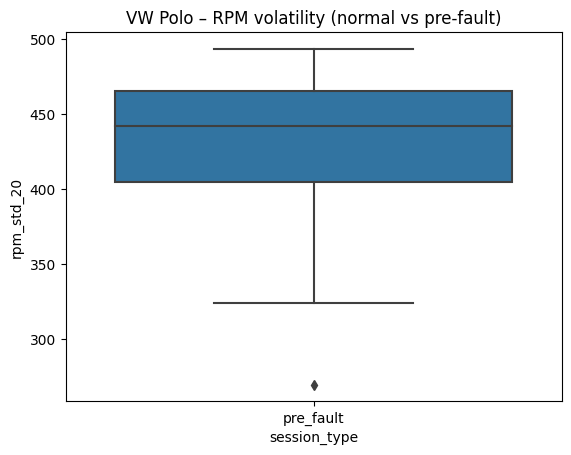

In [87]:
sns.boxplot(data=session_features, x="session_type", y="rpm_std_20")
plt.title("VW Polo – RPM volatility (normal vs pre-fault)")
plt.show()

*VW Polo’da arıza kodu gelmeden önceki sürüşlerde motor devri daha dalgalı hale geliyor. Bu da, powertrain kaynaklı arızalardan önce motorun daha dengesiz çalışmaya başladığını düşündürüyor.*

*Bu değişim her zaman birebir aynı şekilde ortaya çıkmıyor. Bu yüzden tek bir ölçümden ziyade, trend ve oynaklık birlikte değerlendirildiğinde daha anlamlı bir sinyal elde ediliyor.*

In [88]:
# Engine Runtime verisi VW Polo için yeterince dolu olmadığından, session süresi üzerinden bu şekilde harici bir sanity check uyguluyoruz.
session_duration = (vw.groupby(["session_id", "session_type"]).apply(lambda x: (x.index.max() - x.index.min()).total_seconds()).reset_index(name="session_duration_sec"))
session_duration.groupby("session_type")["session_duration_sec"].mean()

session_type
fault        1627.030000
pre_fault    1314.248444
Name: session_duration_sec, dtype: float64

Fault öncesi ve fault içeren sürüş oturumlarının süreleri benzer mertebededir. Bu nedenle, fault öncesi gözlemlenen RPM oynaklığı artışı yalnızca sürüş süresine bağlı değildir.